# HHNK

This script adds a new column "peilgebied_cat" and makes sure the peilgebieden allign with the HWS layer (Daniel):
- peilgebied_cat = 0 -> peilgebied
- peigelbied_cat = 1 -> RHWS (boezem)
- peilgebied_cat = 2 -> NHWS 

In [1]:
import geopandas as gpd
import numpy as np

%load_ext autoreload
%autoreload 2

from general_functions import *

## Set Paths

In [4]:
#define relative paths
waterschap = 'HHNK'
waterschap2 = 'Noorderkwartier'

data_path = f"../projects/4750_20/Data_postprocessed/Waterschappen/{waterschap}/{waterschap2}.gpkg"

# Waterschaps boundaries
grens_path = "../projects/4750_30/Data_overig/Waterschapsgrenzen/Waterschapsgrenzen.geojson"
# Hoofdwatersysteem boundaries
hws_path = "../projects/4750_30/Data_overig/HWS/krw_basins_vlakken.gpkg"
# Buffer boundaries
buffer_path =  "../projects/4750_30/Data_overig/HWS/hws_buffer_hhnk.gpkg"
# Output folder
output_folder = f"./Waterschappen/{waterschap}"

## Load files

In [5]:
# Load HHNK files
HHNK = read_gpkg_layers(gpkg_path = data_path, 
                    variables = ['stuw', 
                                 'gemaal', 
                                 'hydroobject',
                                 'duikersifonhevel',
                                 'peilgebied', 
                                 'streefpeil',
                                ])
HHNK['peilgebied'] = HHNK['peilgebied'].to_crs('EPSG:28992')

# Load waterschap boundaries
gdf_grens = gpd.read_file(grens_path)
gdf_grens = gdf_grens.to_crs('EPSG:28992')
gdf_grens = gdf_grens.set_index('waterschap')

# Load hws
gdf_hws = gpd.read_file(hws_path)

# Load buffer
gdf_buffer = gpd.read_file(buffer_path)

## Select waterschap boundaries and clip hws layer

<Axes: >

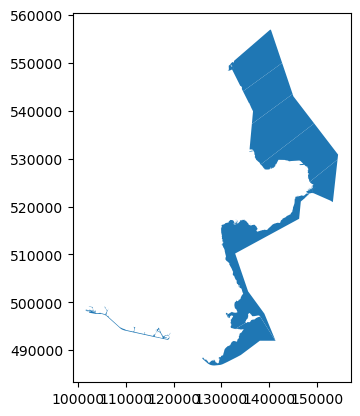

In [17]:
# Select boundaries HH Amstel, Gooi en Vecht
gdf_grens = gdf_grens.loc[['HH Hollands Noorderkwartier']]

# Use waterschap boudnaries to clip HWS layer
gdf_hws = gpd.overlay(gdf_grens, gdf_hws, how='intersection')
gdf_hws.plot()

## Peilgebied and HWS layer overlap:
1. Identify the overlapping areas
2. Clip
3. Calculate overlapping area percentage
4. Filter

In [18]:
# Step 1: Identify the Overlapping Areas and clip
overlaps = gpd.overlay(HHNK['peilgebied'], gdf_hws, how='intersection', keep_geom_type=True)

# # Step 2: Subtract Overlapping Areas from the original polygons in each DataFrame
non_overlapping_peilgebied = gpd.overlay(HHNK['peilgebied'], overlaps, how='difference', keep_geom_type=True)
overlaps = gpd.overlay(non_overlapping_peilgebied, gdf_hws, how='intersection', keep_geom_type=False)
 
# Step 3: Calculate Area Percentages
# Calculate the area of overlaps
overlaps['overlap_area'] = overlaps.area

# Step 4: Filter based on area Area Percentages
minimum_area = 20000
print(f'Number of overlapping shapes without filter: {len(overlaps)}')
overlap_ids = overlaps.loc[overlaps['overlap_area'] > minimum_area]
overlap_ids = overlap_ids.globalid.to_list()
print(f'Number of overlapping shapes with filter: {len(overlap_ids)}')

Number of overlapping shapes without filter: 57
Number of overlapping shapes with filter: 0


## Create peilgebied_cat column

In [19]:
# Add occurence to geodataframe
peilgebieden_cat = []

for index, row in HHNK['peilgebied'].iterrows():
       
    if row.globalid in overlap_ids:
        peilgebieden_cat.append(2)
    
    elif row.HWS_BZM is True:
        peilgebieden_cat.append(1)
        
    elif row.HWS_BZM is False:
        peilgebieden_cat.append(0)
        
# Add new column and drop old HWS_BZM column
HHNK['peilgebied']['peilgebied_cat'] = peilgebieden_cat
HHNK['peilgebied'] = HHNK['peilgebied'].drop(columns=['HWS_BZM'])

## Add nhws to ['peilgebied','streefpeil']

In [20]:
# update peilgebied dict key
gdf_hws['globalid'] = 'dummy_globalid_nhws_' + gdf_hws.index.astype(str)
gdf_hws['code'] = 'dummy_code_nhws_' + gdf_hws.index.astype(str)
gdf_hws['nen3610id'] = 'dummy_nen3610id_nhws_' + gdf_hws.index.astype(str)
gdf_hws['peilgebied_cat'] = 2

gdf_hws = gdf_hws[['globalid', 'code', 'nen3610id', 'peilgebied_cat', 'geometry']]

HHNK['peilgebied'] = pd.concat([gdf_hws, HHNK['peilgebied']])

In [21]:
# Create boezem streefpeil layer
streefpeil_hws = pd.DataFrame()
streefpeil_hws['waterhoogte'] = [np.nan] * len(gdf_hws)
streefpeil_hws['globalid'] = 'dummy_globalid_nhws_' + gdf_hws.index.astype(str)
streefpeil_hws['geometry'] = [None]* len(gdf_hws)

HHNK['streefpeil'] = pd.concat([streefpeil_hws, HHNK['streefpeil']])
HHNK['streefpeil'] = gpd.GeoDataFrame(HHNK['streefpeil'])

### Create layer that ensures spatial match between peilgebied and hws layers based on the buffer layer

In [22]:
# Create buffer polygon
buffer_polygon = gpd.overlay(gdf_buffer, gdf_grens, how='intersection', keep_geom_type=True)
buffer_polygon = gpd.overlay(buffer_polygon, gdf_hws, how='difference', keep_geom_type=True)
buffer_polygon = gpd.overlay(buffer_polygon, HHNK['peilgebied'], how='difference', keep_geom_type=True)

/opt/tljh/user/envs/stable/lib/python3.8/site-packages/geopandas/tools/overlay.py:365: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  result.loc[is_collection, geom_col] = dissolved[geom_col].values
/opt/tljh/user/envs/stable/lib/python3.8/site-packages/geopandas/tools/overlay.py:365: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  result.loc[is_collection, geom_col] = dissolved[geom_col].values


## Add buffer to ['peilgebied','streefpeil']

In [23]:
# update peilgebied dict key
buffer_polygon['globalid'] = 'dummy_globalid_nhws_buffer_' + buffer_polygon.index.astype(str)
buffer_polygon['code'] = 'dummy_code_nhws_buffer_' + buffer_polygon.index.astype(str)
buffer_polygon['nen3610id'] = 'dummy_nen3610id_nhws_buffer_' + buffer_polygon.index.astype(str)
buffer_polygon['peilgebied_cat'] = 2

buffer_polygon = buffer_polygon[['globalid', 'code', 'nen3610id', 'peilgebied_cat', 'geometry']]

HHNK['peilgebied'] = pd.concat([buffer_polygon, HHNK['peilgebied']])

In [24]:
# Create boezem streefpeil layer
streefpeil_buffer = pd.DataFrame()
streefpeil_buffer['waterhoogte'] = [np.nan]
streefpeil_buffer['globalid'] = ['dummy_globalid_nhws_buffer_1']
streefpeil_buffer['geometry'] = [None]


HHNK['streefpeil'] = pd.concat([streefpeil_buffer, HHNK['streefpeil']])
HHNK['streefpeil'] = gpd.GeoDataFrame(HHNK['streefpeil'])



## Write output

In [26]:
for key in HHNK.keys():   
    print(key)
    HHNK[str(key)].to_file(f'{output_folder}/{waterschap2}.gpkg', layer = str(key), driver='GPKG')

stuw
gemaal
hydroobject
duikersifonhevel
peilgebied
streefpeil
